## Do Not change the following cell, just run it

In [12]:
## From stackoverflow: https://stackoverflow.com/questions/12544056/how-do-i-get-the-current-ipython-jupyter-notebook-name/52187331#

from notebook import notebookapp
import urllib
import json
import os
import ipykernel

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

import sys, os, os.path as osp
sys.path += [osp.dirname(osp.dirname(osp.realpath(notebook_path()))), osp.dirname(osp.realpath(notebook_path()))]

In [13]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 400


/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_10124/3758627911.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [14]:
from pathlib import Path
# from cfg.globals import *
sys.path += [str(Path(__file__ if '__file__' in dir() else ".")
                 .resolve().parent.parent)]

In [15]:
import numpy as np
import pandas as pd

## From now on, use the notebook :-)

In [28]:
# !%matplotlib qt
import os
from pathlib import Path
import sys
import glob
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timezone
import pickle
from sklearn.preprocessing import LabelEncoder
import offline.utils as utils
from offline.utils import load_xdf_data

sys.path += [str(Path(__file__ if '__file__' in dir() else ".")
                 .resolve().parent)]

## Reload

In [100]:
import importlib
importlib.reload(utils)
from offline.utils import load_xdf_data


In [104]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import copy
import mne
# from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

np.random.seed(0)

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif,  RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF

import  scipy
from scipy import stats


import time
# Import required packages
import matplotlib as mpl
from pylab import cm
import seaborn as sns
# import matplotlib
# mpl.rcParams['figure.figsize'] = (8, 6)
# plt.rcParams['font.size'] = 15

# # plt.rcParams['legend.fontsize'] = 18
# plt.rcParams['text.usetex'] = False

# plt.rcParams['xtick.direction'] = 'out'
# plt.rcParams['ytick.direction'] = 'out'
# plt.rcParams['xtick.major.size'] = 5.0
# plt.rcParams['xtick.minor.size'] = 5.0
# plt.rcParams['ytick.major.size'] = 5.0
# plt.rcParams['ytick.minor.size'] = 5.0


# plt.rcParams['axes.linewidth'] = lwidth


np.random.seed(0)
import random
random.seed(0)

In [108]:
    

def fisher_rank(x_data, y, sort=True):
    n_feat = x_data.shape[1]
    x_c0 = x_data[y==-1][:]
    x_c1 = x_data[y==1][:]

    d = np.zeros(n_feat)
    for f in range(n_feat):
        d[f] = (np.mean(x_c0[:,f])-np.mean(x_c1[:,f]))**2/(np.var(x_c0[:,f])+np.var(x_c1[:,f]))
    r = np.arange(n_feat)
    if sort:
        r = np.flip( np.argsort(d))
    return r, d[r]


def run_kfold_cv(X_data, y_data, 
                 clf_obj=LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
                 n_folds=10,
                 nested_cv=False,
                 probs=False,
                 thr=.5, 
                 random_state=0):
    skf = StratifiedKFold(n_splits=n_folds, 
                        shuffle=True,
                        random_state=random_state,
                        )
    skf.get_n_splits(X_data, y_data,  )
    # print(skf)
    scores = []
    conf_matrix = np.zeros((n_folds, 4))
    fold_idx=0

    mcr_scores = []
    pr_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    acc_scores = []
    for train_index, test_index in skf.split(X_data, y_data):
    # print(test_index)
    # print("TRAIN:", train_index, "TEST:", test_index)
        X_train_fold, X_test_fold = X_data[train_index], X_data[test_index]
        y_train_fold, y_test_fold = y_data[train_index], y_data[test_index].astype(int)
        clf =  fit_clf(X_train_fold, y_train_fold, copy.deepcopy(clf_obj) )
        # 
        # clf.fit(X_train_fold, y_train_fold) 
        if nested_cv:
            print(f" Best parameters: {clf.best_params_}")
        if probs:
            pred =  clf.predict_proba(X_test_fold)[:,1]
            y_pred_ = np.zeros_like(pred) + min(y_train_fold)
            y_pred_[pred>thr] = 1
            y_pred_ = y_pred_.astype(int)
        # print(y_pred_[:10])
        else:
            pred = clf.predict(X_test_fold)
            y_pred_ = pred

        y_true = y_test_fold

        auc_scores.append(roc_auc_score(y_true, pred))

        pr_scores.append(precision_score(y_true, y_pred_))
        f1_scores.append(f1_score(y_true, y_pred_))
        recall_scores.append(recall_score(y_true, y_pred_))
        acc_scores.append(accuracy_score(y_true, y_pred_))

        tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_).ravel()
        mcr_scores.append((fp+fn)/y_true.shape[0])

        # print(f" tn, fp, fn, tp: {tn, fp, fn, tp}")
        conf_matrix[fold_idx, :] = [tn, fp, fn, tp ]
        fold_idx+=1
        
    test_metrics = {
      'pr_scores': pr_scores,
      'recall_scores': recall_scores,
      'f1_scores': f1_scores,
      'mcr_scores': mcr_scores,
      'acc_scores': acc_scores, 
      'cm_all': conf_matrix,

      'auc_scores': auc_scores
    }

    print(f" Mean {conf_matrix.mean(axis=0)}")
    return  pr_scores, recall_scores, f1_scores, mcr_scores , test_metrics, clf

def fit_clf(xtr, ytr,  clf):
    # clf =  copy.deepcopy(clf_obj) 
    # print(clf)
    clf.fit(xtr, ytr) 
    return clf 

In [18]:

exp_durations = {
    "highlight_length": 0.15,
    "target_length": 2.5,
    "baseline_length": 2,
    "delay_baseline_arrows": 0.1,
    "inter_highlight_length": 0.15,
    "inter_block_length": 3,
    "inter_trial_length": 0.1,
    "num_highlights": 15,
    "target_color": [
        0,
        0,
        255
    ],
    "highlight_color": [
        0,
        255,
        0
    ]
}


def plot_epochs(epochs_data, channel, epochs_ids=None, 
                epochs_inds=None, avg=False, std=False,
                epoch_type=False, ax=None, 
                label=None):
    if epoch_type:
        df_epochs = epochs_data.to_data_frame()
        if epochs_ids is None and (epochs_inds is not None):
            epochs_ids = df_epochs['epoch'].unique()[epochs_ids]
    else:
        df_epochs = epochs_data
    if ax is None:      
        fig, ax = plt.subplot()
    if avg:
        v_arr = None

        for ep in epochs_ids:
            v = df_epochs.loc[(df_epochs['epoch'].isin([ep]))][channel].values
            if v_arr is None:
                v_arr = v
            else:
                v_arr = np.vstack([v_arr, v])

        avg_arr = v_arr.mean(axis=0)
        std_arr = v_arr.std(axis=0)


        plt.plot(df_epochs['time'].unique(), avg_arr, axes=ax, label=label)
        if std:
            plt.fill_between(df_epochs['time'].unique(),
                           avg_arr+std_arr, 
                           avg_arr-std_arr,
                           alpha = .1,
                           color = 'darkorchid',
                           axes=ax)
    # plt.fill_between(ts, mu2+std2, mu2-std2, alpha = .1, color = 'darkorchid')

        if ax is None:
                return ax
    else:

        for ep in epochs_ids:
            v = df_epochs.loc[(df_epochs['epoch'].isin([ep]))][channel].values
#             plt.plot(v)
            plt.plot(df_epochs['time'].unique(), v, axes=ax)
    if ax is None:
        return fig



In [47]:
datadir = '/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data'

In [20]:
file = '/Users/mariyana.cholakova/Downloads/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-008_eeg.xdf'
file = '/Users/mariyana.cholakova/Downloads/eeg/sub-Nathan_ses-long-gb_task-Default_run-003_eeg.xdf'

In [2]:
raw, event_arr_orig, event_id_orig = load_xdf_data(file=file)

NameError: name 'load_xdf_data' is not defined

In [478]:
event_arr = event_arr_orig.copy()
event_id = event_id_orig.copy()

In [22]:

# Implement the band-pass filter
flow, fhigh = 0.1, 10
raw_filt = raw.copy().filter(flow, fhigh)

# Apply Common Average Referencing.
raw_car, _ = mne.set_eeg_reference(raw_filt, 'average', copy=True, ch_type='eeg')

# Now we want to epoch our data to trials and do a baseline correction.
total_trial_duration = exp_durations['baseline_length'] + exp_durations['target_length'] + \
                       exp_durations['highlight_length'] * exp_durations['num_highlights'] + \
                       exp_durations['inter_highlight_length'] * (exp_durations['num_highlights'] - 1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 4225 samples (33.008 sec)

Applying average reference.
Applying a custom ('EEG',) reference.


In [146]:
raw_downsampled = raw_filt.copy().resample(sfreq=32)

In [25]:

flow, fhigh = 1, 20
raw_filt2 = raw.copy().filter(flow, fhigh)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



In [1]:
import matplotlib
# matplotlib.use('Qt5Agg')
# f, axs = plt.subplots(2, 1, figsize=(10, 5))
# _ = f.suptitle('target / non target ', fontsize=20)
# _ = evoked_t.plot(axes=axs[0], show=False, time_unit='s')
# _ = evoked_nt.plot(axes=axs[ 1], show=False, time_unit='s')


raw_filt.plot(duration=10, proj=False, n_channels=len(raw.ch_names),
         remove_dc=True, #axes=axs[0], show=False,
             scalings='auto')
raw_filt2.plot(duration=10, proj=False, n_channels=len(raw.ch_names),
         remove_dc=True, #axes=axs[1], show=False,
             scalings='auto')

plt.tight_layout()

NameError: name 'raw_filt' is not defined

In [ ]:
evplot = ['baseline_for_trial', 'block_end', 
#  'highlight_down', 'highlight_left', 'highlight_right', 'highlight_up',
 'pause', 'target_down', 'target_left', 'target_right', 'target_up', 'trial_begin',
 'highlight_target_true', 'highlight_target_false']

## P300 ?

In [479]:
 new_event_arr, new_event_id= utils.modify_events(event_arr=event_arr, event_id=event_id)

In [513]:
event_id_orig

{'baseline_for_trial': 0,
 'block_end': 1,
 'highlight_down': 2,
 'highlight_left': 3,
 'highlight_right': 4,
 'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11}

In [714]:
event_labels = event_arr_orig[:, 2]
event_times = event_arr_orig[:, 0]

In [563]:
inds_hd = np.where(event_labels==2)[0]
inds_hl = np.where(event_labels==3)[0]
inds_hr = np.where(event_labels==4)[0]
inds_hu = np.where(event_labels==5)[0]

times_hd = event_times[inds_hd]
times_hl = event_times[inds_hl]
times_hr = event_times[inds_hr]
times_hu = event_times[inds_hu]

inds_trial_begin = np.where(event_labels==11)[0]
inds_trial_begin

array([   1,   20,   39,   58,   77,   96,  115,  134,  153,  172,  191,
        210,  229,  248,  267,  286,  305,  324,  343,  362,  381,  400,
        419,  438,  457,  476,  495,  514,  533,  552,  571,  590,  609,
        628,  647,  666,  685,  704,  723,  742,  761,  780,  799,  818,
        837,  856,  875,  894,  913,  932,  951,  970,  989, 1008, 1027,
       1046, 1065, 1084, 1103, 1122, 1141, 1160, 1179, 1198, 1217, 1236,
       1255, 1274, 1293, 1312, 1331, 1350, 1369, 1388, 1407, 1426, 1445,
       1464, 1483, 1502, 1521, 1540, 1559, 1578, 1597, 1616, 1635, 1654,
       1673, 1692, 1711, 1730, 1749, 1768, 1787, 1806])

In [742]:
inds_target_shown = np.where((event_labels>6) & (event_labels<11))[0]
inds_target_shown

array([   2,   21,   40,   59,   78,   97,  116,  135,  154,  173,  192,
        211,  230,  249,  268,  287,  306,  325,  344,  363,  382,  401,
        420,  439,  458,  477,  496,  515,  534,  553,  572,  591,  610,
        629,  648,  667,  686,  705,  724,  743,  762,  781,  800,  819,
        838,  857,  876,  895,  914,  933,  952,  971,  990, 1009, 1028,
       1047, 1066, 1085, 1104, 1123, 1142, 1161, 1180, 1199, 1218, 1237,
       1256, 1275, 1294, 1313, 1332, 1351, 1370, 1389, 1408, 1427, 1446,
       1465, 1484, 1503, 1522, 1541, 1560, 1579, 1598, 1617, 1636, 1655,
       1674, 1693, 1712, 1731, 1750, 1769, 1788, 1807])

In [744]:
targets_seq = event_labels[inds_target_shown]
targets_seq

array([ 9,  7,  8,  9,  7, 10,  8, 10,  8,  9,  9, 10,  7, 10,  7,  8,  9,
        8,  7,  7, 10, 10,  9,  8, 10,  7,  8,  8,  9, 10,  7,  9,  8,  7,
       10,  8,  9,  7, 10,  9, 10,  9,  7,  8,  7, 10,  9,  8, 10,  7,  8,
        9, 10,  9,  8,  7,  8,  9,  7, 10,  9, 10,  7,  8, 10,  9, 10,  8,
        7,  8,  7,  9, 10,  7,  9,  7, 10,  9,  8,  8,  7,  8,  9,  8,  9,
       10, 10,  7, 10,  9,  9,  8, 10,  8,  7,  7])

In [521]:
event_times[trial_ind]

array([   425,   1435,   2339,   3348,   4363,   5266,   6177,   7186,
         8454,   9393,  10368,  11305,  12261,  13214,  14155,  15151,
        19142,  20114,  21016,  21928,  22934,  23877,  24846,  25750,
        27433,  28421,  29318,  30290,  31223,  32228,  33150,  34174,
        37276,  38211,  39180,  40110,  41043,  41960,  42957,  43881,
        46696,  47661,  48609,  49608,  50542,  51552,  52514,  53472,
        55725,  56683,  57628,  58579,  59494,  60474,  61373,  62392,
        64239,  65141,  66098,  67084,  67992,  68945,  69917,  70937,
        73246,  74186,  75198,  76192,  77161,  78101,  79007,  79975,
        81629,  82543,  83518,  84530,  85492,  86393,  87359,  88272,
        89940,  90857,  91812,  92835,  93823,  94799,  95803,  96727,
        98483,  99491, 100460, 101440, 102382, 103288, 104221, 105242])

In [524]:
t_start = event_times[trial_ind] - 1000
t_end = t_start + total_trial_duration
t_start, t_end, event_times[trial_ind]

(-575, -566.15, 425)

In [527]:
total_trial_duration

8.85

In [726]:
for i, trial_ind in enumerate(inds_trial_begin):
    target_ = event_labels[inds_target_shown[i]]
    
    t_start = (event_times[trial_ind])/1000
    t_end = t_start + total_trial_duration
    print(t_start, t_end)

    trial_data = raw_filt2.to_data_frame()
    trial_data = trial_data[(trial_data['time']> t_start) & (trial_data['time']< t_end)]
    
    event_arr_ = event_arr_orig.copy()
    event_arr_[:, 0] = event_arr_[:, 0] - t_start*1000
    
    raw_copy = raw_filt2.copy()
    raw_copy.crop(tmin=t_start, tmax=t_end)
    epochs_ = mne.Epochs(raw_copy,
                         event_arr_,
                         event_id_orig, 
                         tmin=-.1,
                         tmax=total_trial_duration,
                         baseline=(None, 0),
                         preload=True, 
                        event_repeated='drop',
                         decim=2)
    break
    
    
#     up_highlights = epochs_.e

0.425 9.275


In [727]:
epochs_

Number of events,0
Events,baseline_for_trial: 0block_end: 0highlight_down: 0highlight_left: 0highlight_right: 0highlight_up: 0pause: 0trial_begin: 0
Time range,-0.094 – 8.844 sec
Baseline,-0.094 – 0.000 sec


In [31]:
from global_configs import globals as GLOB

In [662]:
event_id2 = {'base_trial': 0,
 'b_end': 1,
#  'h_d': 2,
#  'h_l': 3,
#  'h_r': 4,
#  'h_u': 5,
 'pause': 6,
 't_d': 7,
 't_l': 8,
 't_r': 9,
 't_u': 10,
 'tr_begin': 11,
            'h':20}
epochs_highlights_ = mne.Epochs(raw_filt2,
                                       events=event_arr_mod,
                                       event_id= {'h':20},
                                       tmin=.1,
                                       tmax=.5,
                                       baseline=None,
                                       preload=True, 
                               event_repeated='drop', decim=2)

In [664]:
epochs_highlights_[0].get_data().shape

(1, 14, 26)

In [740]:
event_id_mod

{'baseline_for_trial': 0,
 'block_end': 1,
 'highlight_down': 2,
 'highlight_left': 3,
 'highlight_right': 4,
 'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11,
 'h': 20}

In [577]:
highlights_seq = event_arr_orig[:, 2][event_arr_mod[:, 2]==20]

In [580]:
highlights_seq.shape

(1440,)

In [638]:
highlights_per_trial = 15


In [763]:
targets_final = []
highlights_final_epochs = []
highlights_labels = []
j = 0

for i in np.arange(0, len(epochs_highlights_), highlights_per_trial):
    ep = epochs_highlights_[i: i+15]
    highlight_labels = highlights_seq[i: i+15]
    target_ = targets_seq[j]
    j+=1
    epochs_down = ep[highlight_labels==2].average()  
    epochs_left = ep[highlight_labels==3].average()   
    epochs_right = ep[highlight_labels==4].average()    
    epochs_up = ep[highlight_labels==5].average()
    highlights_final_epochs.append(epochs_down)
    highlights_final_epochs.append(epochs_left)

    highlights_final_epochs.append(epochs_right)

    highlights_final_epochs.append(epochs_up)

    highlights_labels.extend([ 2,3, 4, 5])
    targets_final.extend([target_] * 4)

In [764]:
chnum , size = highlights_final_epochs[0].get_data().shape

In [765]:
len(highlights_labels), len(targets_final)

(384, 384)

In [766]:
t_samples = [x for x in range(len(targets_final)) if highlights_labels[x]==targets_final[x] -5]
len(t_samples)

96

In [767]:
y = np.zeros(len(highlights_final_epochs
                ))
y[t_samples]=1

In [768]:
chnum, size

(14, 26)

In [769]:
x = np.concatenate([x.get_data().reshape(1, chnum, size ) for x in highlights_final_epochs])

In [770]:
x.shape

(384, 14, 26)

In [615]:
raw.ch_names

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

In [771]:
ind_selected_ch = [i for i, x in enumerate(raw.ch_names) if x in selected_ch]

In [568]:
events_seq = event_arr_orig[:, 2]

# target_events_seq = np.zeros_like(events_seq)

highlight_inds = (events_seq > 1) & (events_seq < 6)
event_arr_mod = event_arr_orig.copy()
event_arr_mod[highlight_inds, 2] = 20

event_id_mod = event_id_orig.copy()
event_id_mod.update({'h': 20})


In [525]:
epochs_highlights_

Number of events,1728
Events,b_end: 12base_trial: 96h_d: 369h_l: 365h_r: 358h_u: 348pause: 84tr_begin: 96
Time range,-0.500 – 8.844 sec
Baseline,off


In [510]:
epochs_highlights_['tr_begin'][0]

Number of events,1
Events,tr_begin: 1
Time range,-0.500 – 8.844 sec
Baseline,off


In [ ]:
epochs_highlights_['trial'].set_annotations()

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Opening epochs-browser...


/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_10124/2345730344.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  epochs_highlights_.plot(events=event_arr_orig, event_id=event_id2, n_epochs=1, scalings='auto', )


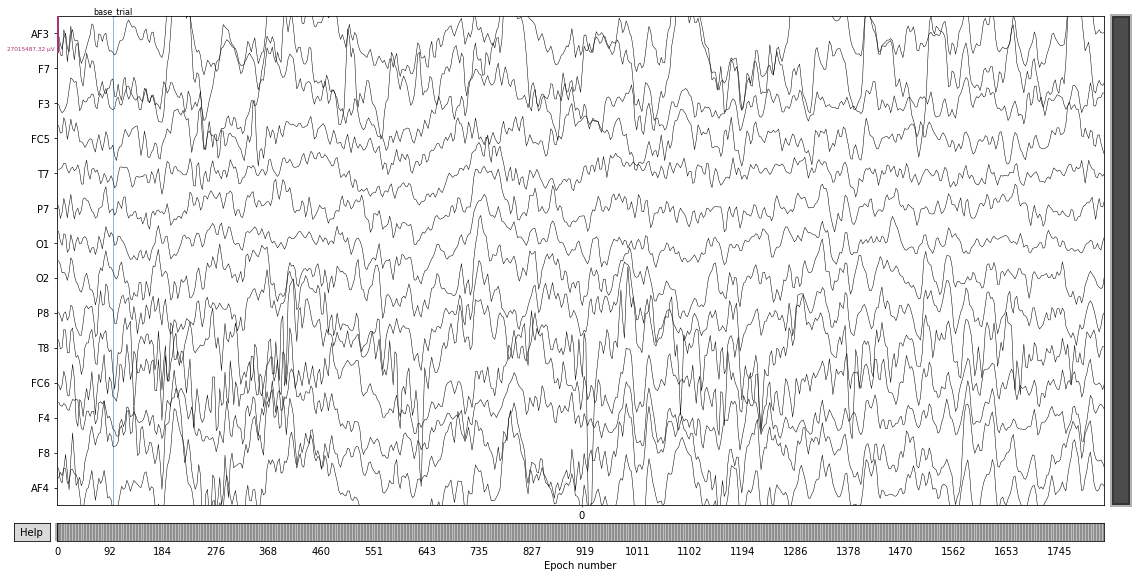

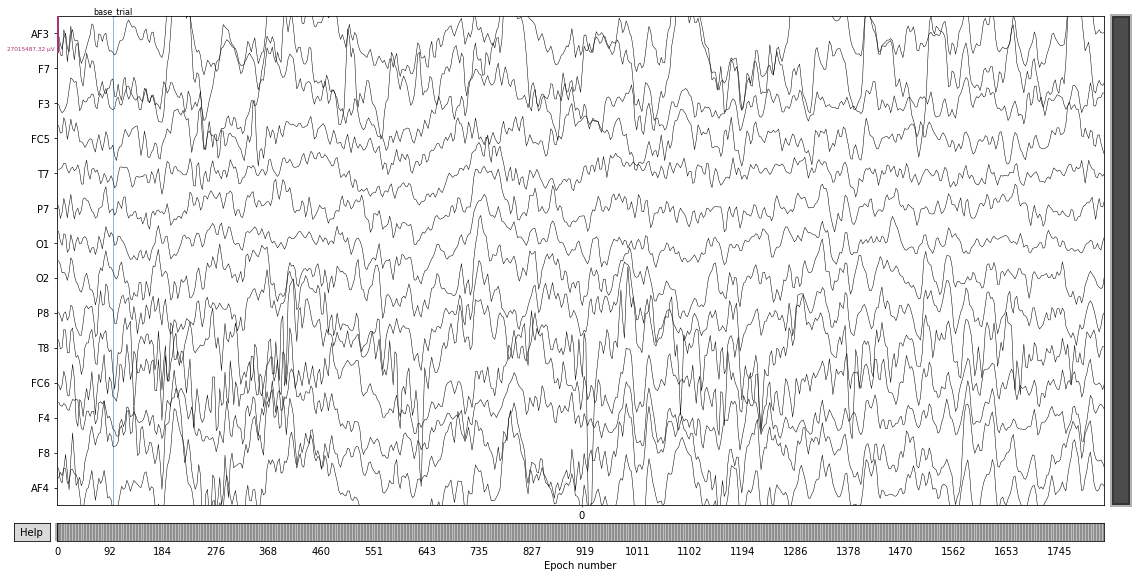

In [491]:

# trials = mne.pick_events(event_arr, include=[event_id2.values()])
epochs_highlights_.plot(events=event_arr_orig, event_id=event_id2, n_epochs=1, scalings='auto', )
# #                     event_color=dict(button='red', face='blue')

In [492]:
epochs_highlights_

Number of events,1728
Events,b_end: 12base_trial: 96h_d: 369h_l: 365h_r: 358h_u: 348pause: 84tr_begin: 96
Time range,-0.500 – 8.844 sec
Baseline,off


In [493]:
epochs_highlights_['tr_begin']

Number of events,96
Events,tr_begin: 96
Time range,-0.500 – 8.844 sec
Baseline,off


In [497]:
for tr in epochs_highlights_['tr_begin']

TypeError: getfield() missing required argument 'dtype' (pos 1)

In [ ]:
picks  = ['O2']
tmin = 0
tmax = .5
epochs1 = mne.Epochs(raw_filt2, event_arr, 100, tmin, tmax, picks=picks,
                     baseline=None, )

In [32]:
epochs_highlights_notargets = mne.Epochs(raw_filt,
                                         events=event_arr,
                                         event_id={GLOB.HIGHLIGHT_TARGET_FALSE: 99},
                                         tmin=0,
                                         tmax=.7,
                                         baseline=None,
                                         preload=True)

epochs_highlights_targets = mne.Epochs(raw_filt,
                                       events=event_arr,
                                       event_id={GLOB.HIGHLIGHT_TARGET_TRUE: 100},
                                       tmin=0,
                                       tmax=.7,
                                       baseline=None,
                                       preload=True)
epochs_highlights_notargets2 = mne.Epochs(raw_filt2,
                                         events=event_arr,
                                         event_id={GLOB.HIGHLIGHT_TARGET_FALSE: 99},
                                         tmin=0,
                                         tmax=.7,
                                         baseline=None,
                                         preload=True)

epochs_highlights_targets2 = mne.Epochs(raw_filt2,
                                       events=event_arr,
                                       event_id={GLOB.HIGHLIGHT_TARGET_TRUE: 100},
                                       tmin=0,
                                       tmax=.7,
                                       baseline=None,
                                       preload=True)

Not setting metadata
1095 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1095 events and 91 original time points ...
0 bad epochs dropped
Not setting metadata
345 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 345 events and 91 original time points ...
0 bad epochs dropped
Not setting metadata
1095 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1095 events and 91 original time points ...
0 bad epochs dropped
Not setting metadata
345 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 345 events and 91 original time points ...
0 bad epochs dropped


In [95]:
epochs_highlights_targets2.get_data().shape, epochs_highlights_targets2.to_data_frame().shape

((345, 14, 91), (31395, 17))

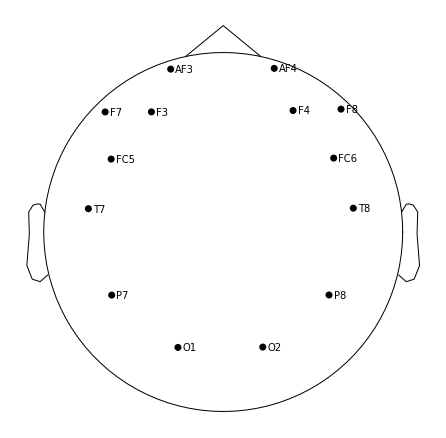

In [34]:

fig= raw_car.plot_sensors(ch_type='eeg', show_names=True,
                             title='Available Channels', show=True )

<Figure size 288x720 with 0 Axes>

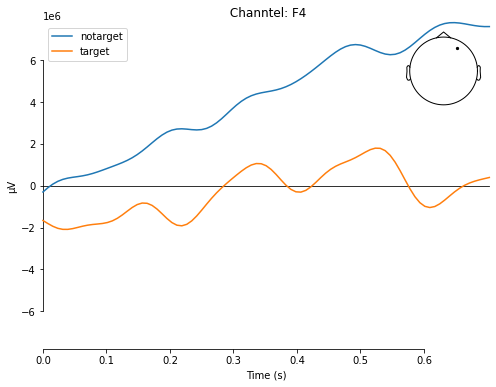

<Figure size 288x720 with 0 Axes>

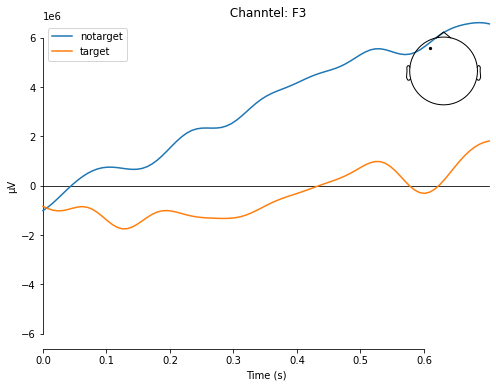

<Figure size 288x720 with 0 Axes>

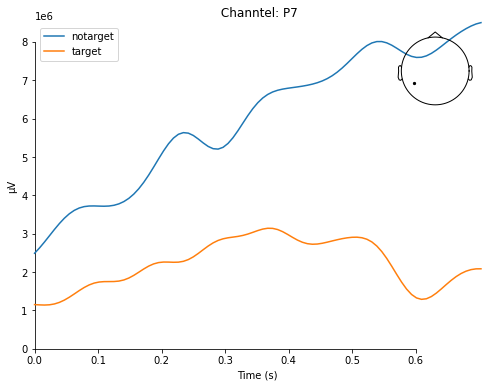

[<Figure size 576x432 with 2 Axes>]

In [35]:
plt.figure(figsize=(4, 10))
ch = 'F4'#'P7'
t2 = 350
inv_y = 0
# average the signals for channel Cz for both conditions:
avg_nt = epochs_highlights_notargets[:t2].average(picks=ch)
avg_t = epochs_highlights_targets.average(picks=ch)

# Plot the evoked potentials
evokeds = dict(notarget=avg_nt, target=avg_t)
mne.viz.plot_compare_evokeds(evokeds,  invert_y=inv_y, title=f" Channtel: {ch}")

plt.figure(figsize=(4, 10))
ch = 'F3'#'P7'
# average the signals for channel Cz for both conditions:
avg_nt = epochs_highlights_notargets[:t2].average(picks=ch)
avg_t = epochs_highlights_targets.average(picks=ch)

# Plot the evoked potentials
evokeds = dict(notarget=avg_nt, target=avg_t)
mne.viz.plot_compare_evokeds(evokeds, invert_y=inv_y, title=f" Channtel: {ch}")

plt.figure(figsize=(4, 10))
ch = 'P7'#'P7'
# average the signals for channel Cz for both conditions:
avg_nt = epochs_highlights_notargets[:t2].average(picks=ch)
avg_t = epochs_highlights_targets.average(picks=ch)

# Plot the evoked potentials
evokeds = dict(notarget=avg_nt, target=avg_t)
mne.viz.plot_compare_evokeds(evokeds, invert_y=inv_y, title=f" Channtel: {ch}")

In [772]:
y

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1.

In [655]:
selected_ch, ind_selected_ch

(['P8', 'P7', 'FC6', 'O1', 'O2'], [5, 6, 7, 8, 10])

In [675]:
highlights_final_epochs[0].ch_names

['P7']

In [676]:
highlights_final_epochs[0].get_data().shape

(1, 26)

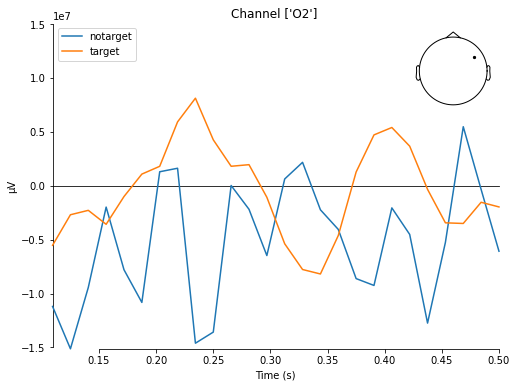

In [775]:
# avg_nt = epochs_highlights_notargets2_decim[:600].average(picks=ch)
# avg_t = epochs_highlights_targets2_decim.average(picks=ch)

# Plot the evoked potentials
evokeds = dict(notarget=highlights_final_epochs[0].copy().pick(10), target=highlights_final_epochs[4].copy().pick(10))
mne.viz.plot_compare_evokeds(evokeds, invert_y=0, title=f'Channel {ch} ')
plt.show()

<Figure size 288x720 with 0 Axes>

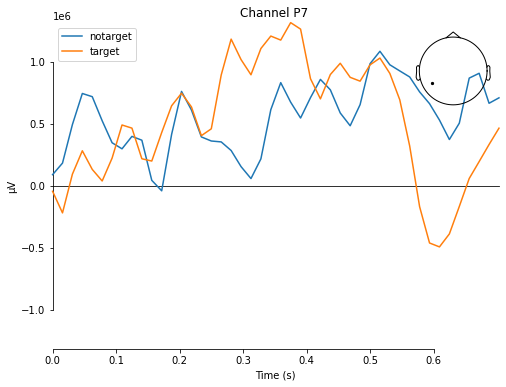

<Figure size 288x720 with 0 Axes>

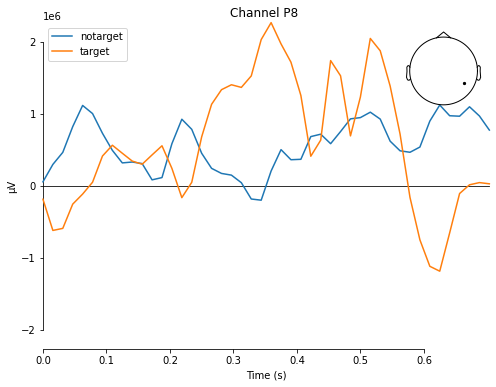

<Figure size 288x720 with 0 Axes>

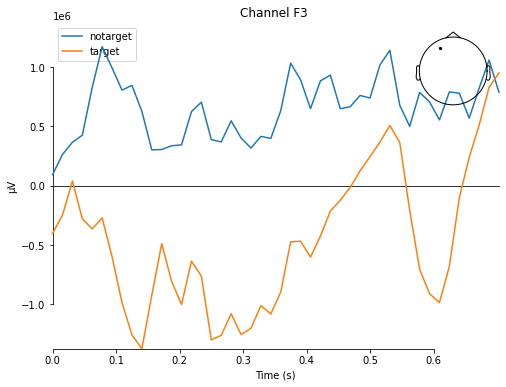

<Figure size 288x720 with 0 Axes>

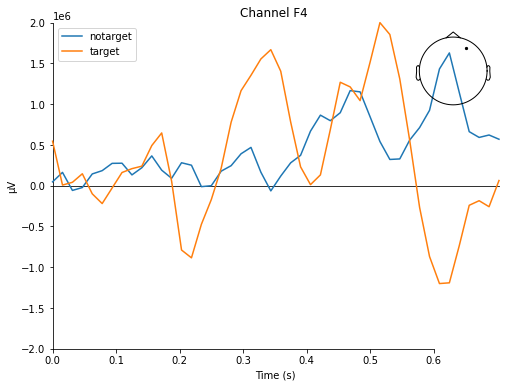

<Figure size 288x720 with 0 Axes>

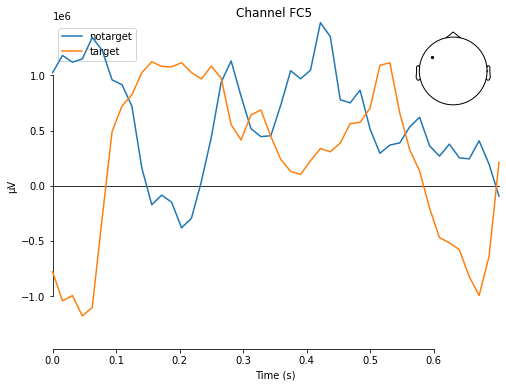

<Figure size 288x720 with 0 Axes>

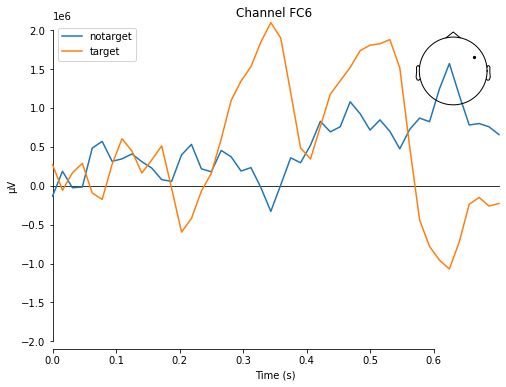

<Figure size 288x720 with 0 Axes>

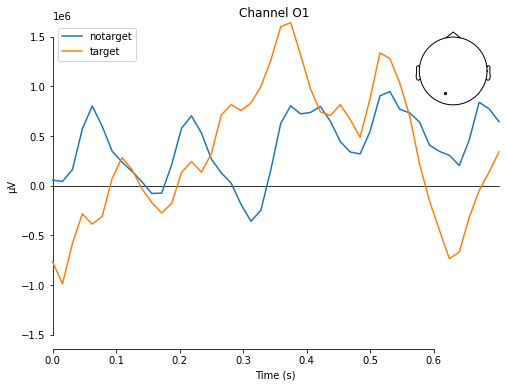

<Figure size 288x720 with 0 Axes>

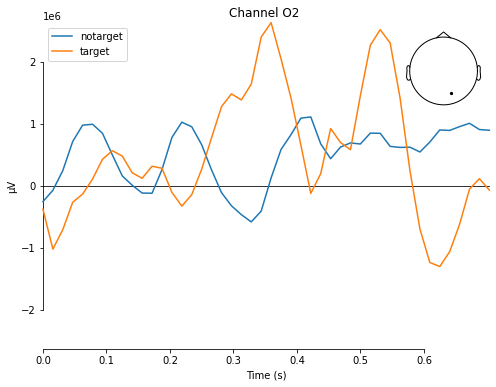

In [77]:
chans = ['P7', 'P8', 'F3', 'F4', 'FC5', 'FC6', 'O1', 'O2']
for ch in chans:
    plt.figure(figsize=(4, 10))
    # ch = 'F3'#'P7'
    # average the signals for channel Cz for both conditions:
    avg_nt = epochs_highlights_notargets2_decim[:600].average(picks=ch)
    avg_t = epochs_highlights_targets2_decim.average(picks=ch)

    # Plot the evoked potentials
    evokeds = dict(notarget=avg_nt, target=avg_t)
    mne.viz.plot_compare_evokeds(evokeds, invert_y=0, title=f'Channel {ch} ')
    plt.show()

In [78]:
selected_channels = ['P8', 'FC6', 'O1', 'O2', 'P7']

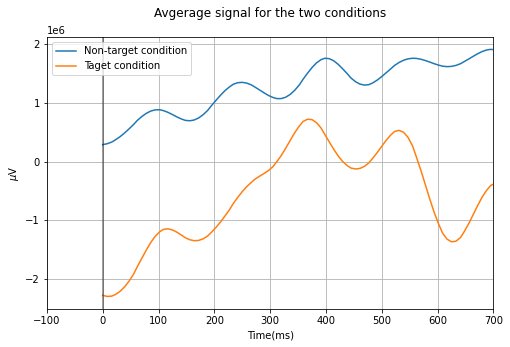

In [45]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
df_epochs_plt = epochs_highlights_notargets.to_data_frame()
df_epochs_plt2 = epochs_highlights_targets.to_data_frame()

epochs_ids = df_epochs_plt['epoch'].unique()[:]
epochs_ids2 = df_epochs_plt2['epoch'].unique()[:]
ch='O1'
fig_2 = plot_epochs(df_epochs_plt, channel = ch,
                    epochs_ids = epochs_ids,
                    avg=1 , std=0,
                    ax=ax,
                    label='Non-target condition')

fig_2 = plot_epochs(df_epochs_plt2, channel = ch,
                    epochs_ids = epochs_ids2,
                    avg=1 , std=0,
                    ax=ax,
                    label='Taget condition')

plt.legend(loc='upper left')
plt.title('Avgerage signal for the two conditions', pad=20)
plt.xlabel('Time(ms)')
plt.ylabel('$\mu$V')
plt.axvline(x=0, c='k', alpha=.5)
plt.grid()

ax.set_xlim(-100, 700)

fig_filename = 'avg_pred_alt.png'
# plt.savefig(fig_filename, dpi = 300, bbox_inches = 'tight', pad_inches = .1)

/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_10124/422407899.py:3: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  fig = evoked_nt.plot_topomap(times, ch_type='eeg', average=0.05, time_unit='s')


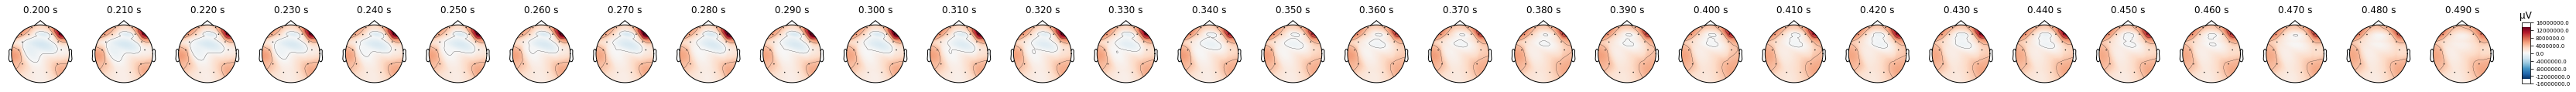

/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_10124/422407899.py:4: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  fig = evoked_t.plot_topomap(times, ch_type='eeg', average=0.05, time_unit='s')


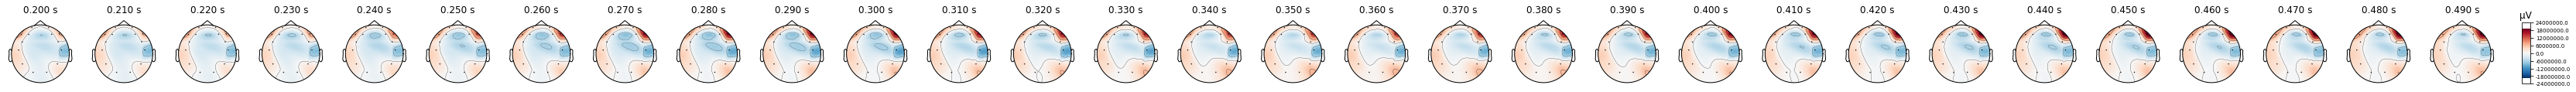

In [49]:
times = np.arange(.2, .5, .01
          )
fig = evoked_nt.plot_topomap(times, ch_type='eeg', average=0.05, time_unit='s')
fig = evoked_t.plot_topomap(times, ch_type='eeg', average=0.05, time_unit='s')

In [48]:

# Save the evoked signals
epochs_highlights_notargets.average().save(datadir + '/avg_nt.fif', 
        overwrite=True);
epochs_highlights_targets.average().save(datadir + '/avg_t.fif', 
        overwrite=True);

f=datadir + '/avg_nt.fif'
# fig, axes = plt.subplots(ncols=3, figsize=(8, 8))
evoked_nt =  mne.Evoked(f)
f2=datadir + '/avg_t.fif'
evoked_t = mne.Evoked(f2)

Overwriting existing file.
Overwriting existing file.
    Found the data of interest:
        t =       0.00 ...     703.12 ms (highlight_target_false)
        0 CTF compensation matrices available
        nave = 1095 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
    Found the data of interest:
        t =       0.00 ...     703.12 ms (highlight_target_true)
        0 CTF compensation matrices available
        nave = 345 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.


/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_10124/4221130386.py:2: RuntimeWarning: This filename (/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/avg_nt.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  epochs_highlights_notargets.average().save(datadir + '/avg_nt.fif',
/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_10124/4221130386.py:4: RuntimeWarning: This filename (/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/avg_t.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  epochs_highlights_targets.average().save(datadir + '/avg_t.fif',


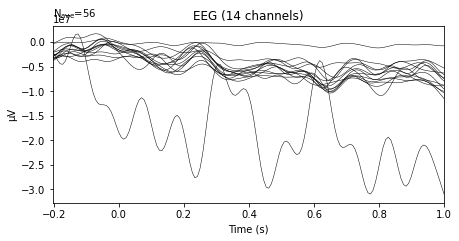

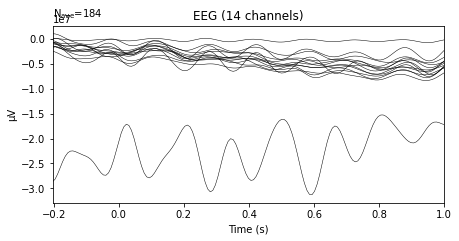

In [104]:


f = evoked_t.plot()
f2 = evoked_nt.plot()

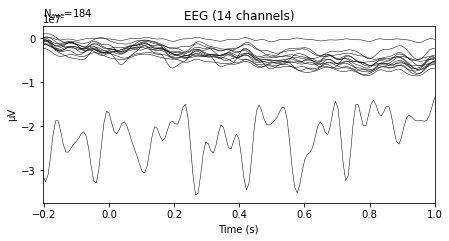

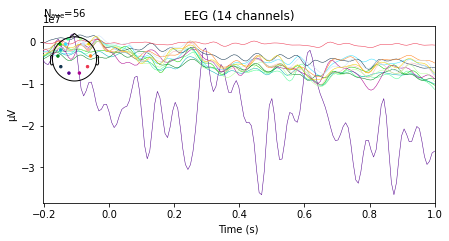

In [62]:
fig1 = evoked_nt.plot()
fig2 = evoked_t.plot(spatial_colors=True)

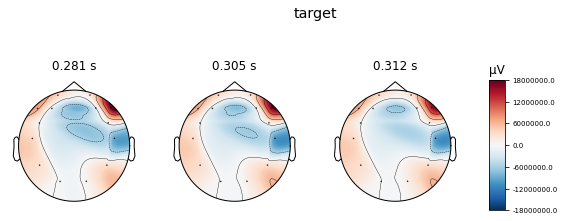

In [207]:
times = [ .281, .305,  .312]
# times = [.266, 0.273, 0.281, 0.289,
#        0.297, 0.305, 0.312, 0.32 , 0.328, 0.336,]
# times = [0.156, 0.164, 0.172, 0.18 , 0.188, 0.195, 0.203, 0.211, 0.219,
#        0.227, 0.234, 0.242, 0.25 , 0.258, 0.266, 0.273, 0.281, 0.289,
#        0.297, 0.305, 0.312, 0.32 , 0.328, 0.336, 0.344, 0.352, 0.359,
#        0.367, 0.375, 0.383]
d = evoked_t.plot_topomap(times, ch_type='eeg', time_unit='s', title='target',
                        # axes=axes[0:]
                         size=1.5,
                        # show_names=True,
                        res=256

                        )

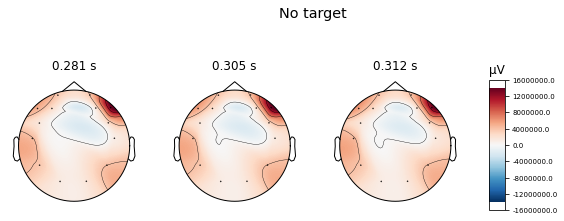

In [208]:

d2 = evoked_nt.plot_topomap(times, ch_type='eeg', time_unit='s',  title='No target ',
                        #  axes=axes[:]
                         size=1.5
)

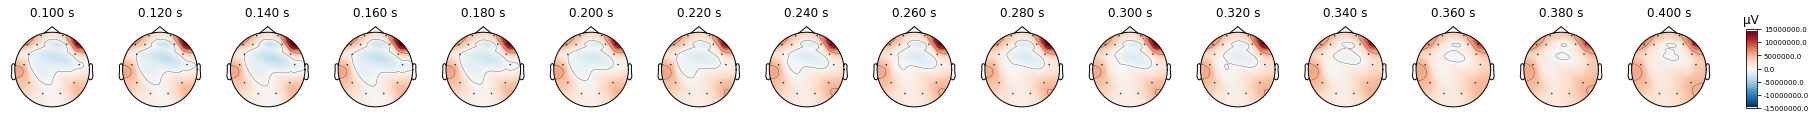

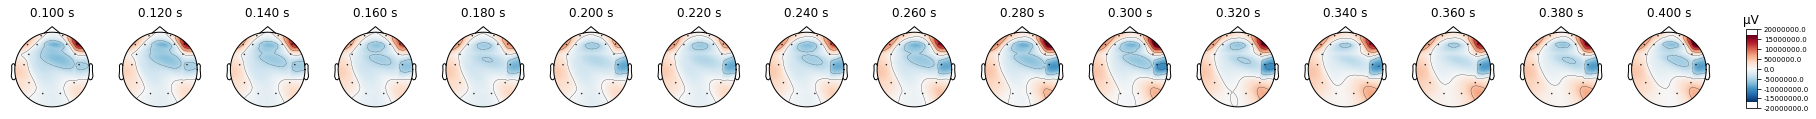

In [206]:
times = np.arange(.1, .4, .02
          )
fig = evoked_nt.plot_topomap(times, ch_type='eeg', average=0.05, time_unit='s')
fig = evoked_t.plot_topomap(times, ch_type='eeg', average=0.05, time_unit='s')

# detect bad channels automaticlly 

In [53]:

from scipy import signal as signal
from time import perf_counter

from pyprep.find_noisy_channels import NoisyChannels

###############################################################################
# Assign the mne object to the :class:`NoisyChannels` class. The resulting object
# will be the place where all following methods are performed.

nd = NoisyChannels(raw, random_state=1337)
nd2 = NoisyChannels(raw, random_state=1337)

###############################################################################
# Find all bad channels using channel-wise RANSAC and print a summary
start_time = perf_counter()
nd.find_bad_by_ransac(channel_wise=True)
print("--- %s seconds ---" % (perf_counter() - start_time))

# Repeat channel-wise RANSAC using a single channel at a time. This is slower
# but needs less memory.
start_time = perf_counter()
nd2.find_bad_by_ransac(channel_wise=True, max_chunk_size=1)
print("--- %s seconds ---" % (perf_counter() - start_time))

###############################################################################
# Now the bad channels are saved in `bads` and we can continue processing our
# `raw` object. For more information, we can access attributes of the ``nd``
# instance:

# Check channels that go bad together by correlation (RANSAC)
print(nd.bad_by_ransac)
# assert set(bad_ch_names) == set(nd.bad_by_ransac)

# Check that the channel wise RANSAC yields identical results
print(nd2.bad_by_ransac)
# assert set(bad_ch_names) == set(nd2.bad_by_ransac)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 14
Total # of chunks: 1
Current chunk: 1 
RANSAC done!
--- 4.701157133007655 seconds ---
Executing R

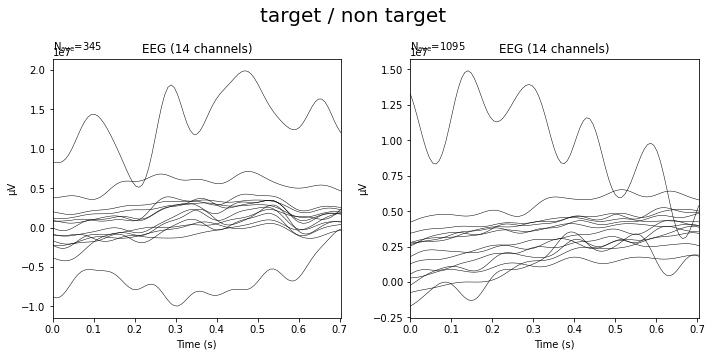

In [54]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
_ = f.suptitle('target / non target ', fontsize=20)
_ = evoked_t.plot(axes=axs[0], show=False, time_unit='s')
_ = evoked_nt.plot(axes=axs[ 1], show=False, time_unit='s')
plt.tight_layout()

In [502]:
epochs_highlights_['tr_begin'][0].to_data_frame()

,time,condition,epoch,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-500,tr_begin,1,3.704092e+07,3.917703e+07,3.617896e+07,1.072968e+07,6.266609e+06,3.749084e+06,2.987338e+06,8.657743e+06,2.515337e+07,5.574278e+07,2.385173e+07,3.652631e+07,3.439381e+07,4.075079e+07
1,-484,tr_begin,1,2.629316e+07,2.494884e+07,3.103011e+07,1.063478e+07,4.416016e+06,-3.386160e+06,3.720832e+06,9.549059e+06,2.349809e+07,3.952942e+07,1.163764e+06,3.152121e+07,2.153501e+07,2.987013e+07
2,-469,tr_begin,1,1.385148e+07,1.353548e+07,1.657920e+07,8.993169e+06,4.733122e+06,-2.602496e+06,5.093426e+06,6.148509e+05,9.468459e+06,5.890552e+06,-4.219522e+06,2.110269e+07,-2.700589e+06,1.783553e+07
3,-453,tr_begin,1,1.593505e+07,1.384840e+07,1.098863e+07,1.006214e+07,4.994275e+06,-1.540317e+06,7.457910e+06,-7.978971e+06,5.247981e+04,1.564043e+07,6.032732e+06,1.479916e+07,-6.534856e+06,1.774375e+07
4,-438,tr_begin,1,2.101451e+07,1.766743e+07,1.845147e+07,1.207744e+07,6.150013e+06,-2.317858e+06,9.050093e+06,-3.042311e+06,1.194585e+07,3.498490e+07,8.785322e+06,1.875567e+07,7.086007e+06,2.667119e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,8781,tr_begin,1,8.634878e+06,3.057038e+07,-1.587502e+06,6.901516e+06,9.414228e+06,4.351884e+06,9.641684e+06,1.560457e+07,3.513483e+06,2.167915e+07,4.954745e+06,-2.561542e+06,5.360292e+06,7.274903e+06
595,8797,tr_begin,1,-1.731319e+06,5.293304e+07,-7.011208e+06,6.025691e+04,5.756984e+06,-6.642367e+06,7.037999e+05,5.573414e+06,-3.814641e+06,-4.127355e+06,-1.020235e+07,-1.035543e+07,-8.025876e+06,-3.836090e+06
596,8812,tr_begin,1,3.074666e+06,5.686521e+07,-4.038556e+06,4.303282e+06,-3.211596e+06,-6.038381e+06,-4.314997e+06,-5.118907e+06,-1.256242e+07,-1.613128e+07,-1.256818e+07,-7.469634e+06,-9.490959e+06,-3.651405e+06
597,8828,tr_begin,1,9.824791e+06,5.217876e+07,2.810039e+06,5.590561e+06,-2.947246e+06,-2.793922e+06,-7.267455e+06,-8.034057e+06,-1.389671e+07,-7.612713e+06,-6.414876e+06,-3.614100e+06,-6.123347e+06,-2.916298e+06


In [69]:
picks  = ['O2']
tmin = 0
tmax = .5
epochs1 = mne.Epochs(raw_filt2, event_arr, 100, tmin, tmax, picks=picks,
                     baseline=None, )
condition1 = epochs1.get_data()  # as 3D matrix

epochs2 = mne.Epochs(raw_filt2, event_arr, 99, tmin, tmax, picks=picks,
                     baseline=None, )
condition2 = epochs2.get_data()  # as 3D matrix

condition1 = condition1[:, 0, :]  # take only one channel to get a 2D array
condition2 = condition2[:, 0, :]  # take only one channel to get a 2D array

Not setting metadata
345 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 345 events and 65 original time points ...
0 bad epochs dropped
Not setting metadata
1095 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1095 events and 65 original time points ...
0 bad epochs dropped


In [70]:

from mne.stats import permutation_cluster_test
from mne.datasets import sample
threshold = 6.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=1, n_jobs=1,
                             out_type='mask')

stat_fun(H1): min=0.000023 max=8.117058
Running initial clustering
Found 1 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


NameError: name 'h' is not defined

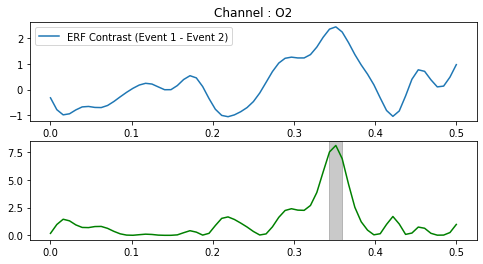

In [71]:
times = epochs1.times
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
channel = picks[0]
ax.set_title('Channel : ' + channel)
ax.plot(times, condition1.mean(axis=0) - condition2.mean(axis=0),
        label="ERF Contrast (Event 1 - Event 2)")
ax.set_ylabel("")
ax.legend()

for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        h = ax2.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.1)
    else:
        ax2.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3),
                    alpha=0.3)

hf = plt.plot(times, T_obs, 'g')
ax2.legend((h, ), ('cluster p-value < 0.05', ))
ax2.set_xlabel("time (ms)")
ax2.set_ylabel("f-values")

In [155]:
raw_car.ch_names

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

## decimate

In [73]:
epochs_highlights_notargets2_decim = epochs_highlights_notargets2.copy().decimate(2)

In [74]:
epochs_highlights_targets2_decim = epochs_highlights_targets2.copy().decimate(2)

In [282]:
epochs_highlights_notargets2.get_data().shape, epochs_highlights_notargets2_decim.get_data().shape

((1095, 14, 91), (1095, 14, 46))

In [101]:
x, y = utils.get_labeled_dataset(epochs_highlights_targets2_decim, epochs_highlights_notargets2_decim)

In [102]:
x.shape, y.shape

((1440, 14, 46), (1440,))

In [290]:
x_avg_3= np.zeros((int(x.shape[0]/3), x.shape[1], x.shape[2]))
y_avg_3 = np.zeros((int(x.shape[0]/3)))

In [293]:
ch_picks = selected_channels
ch_scores_mi = np.zeros((len(ch_picks), x.shape[2]))
ch_scores_f = np.zeros((len(ch_picks), x.shape[2]))
ch_scores_f_rank = np.zeros((len(ch_picks), x.shape[2]))

for i in range(len(ch_picks)):
    sub_x = x_avg_3[:, i, :]

    mi_statistics = mutual_info_classif(sub_x, y_avg_3)
    f_statistics, pvals = f_classif(sub_x, y_avg_3)
    ranks_f = np.argsort(f_statistics)   
#     ranked_ind, scores = fisher_rank(sub_x, y)
    ch_scores_mi[i, :] = mi_statistics
    ch_scores_f[i, :] = f_statistics

<AxesSubplot:>

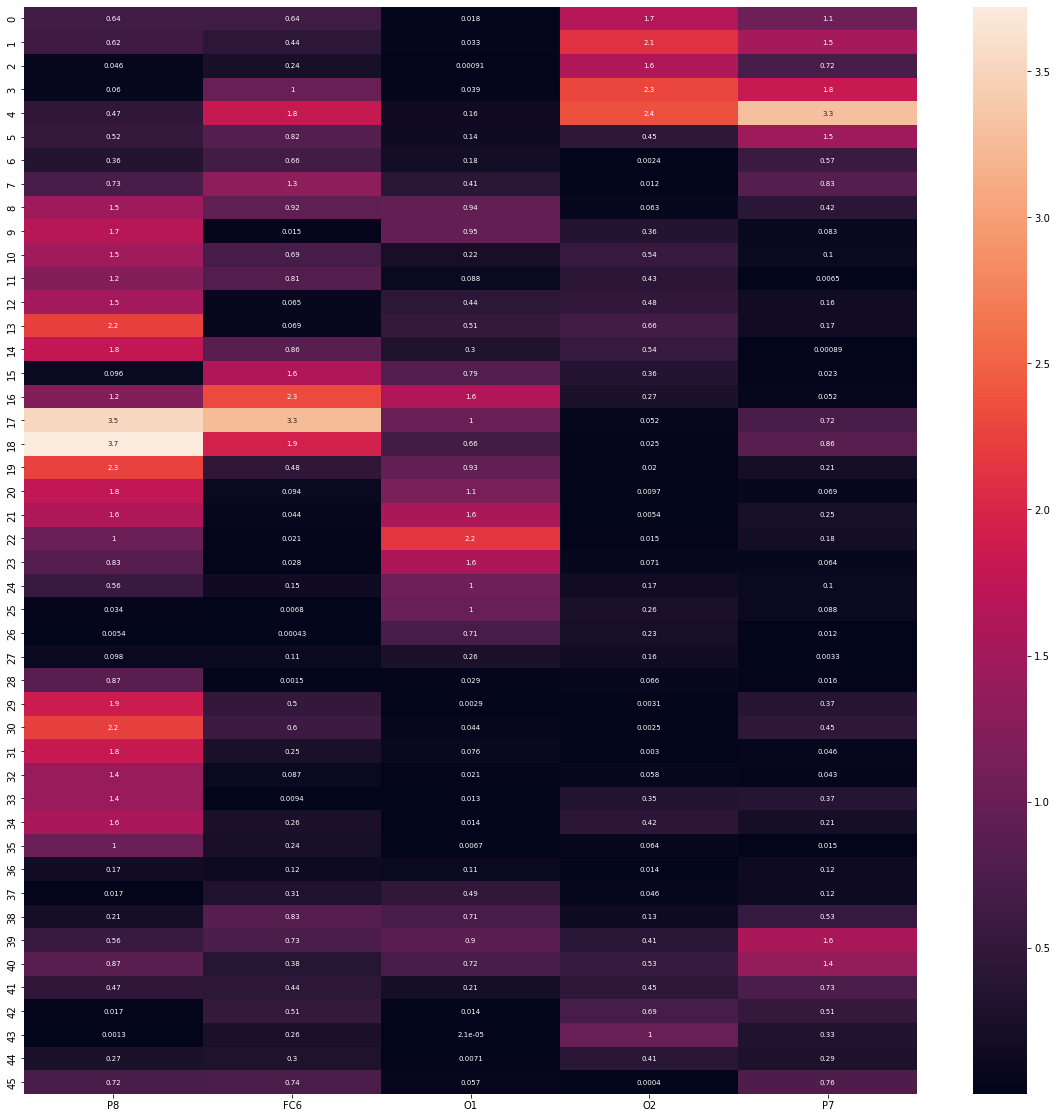

In [294]:

# Create a dataset
df = pd.DataFrame(ch_scores_f.T, columns=ch_picks)
plt.figure(figsize=(20, 20))
# plot a heatmap with annotation
sns.heatmap(df, annot=True, annot_kws={"size": 7})

In [113]:
x.min(), x.max()

(-814.6568314091043, 961.5686827201165)

In [295]:
selected_ch = ['P8', 'P7', 'FC6', 'O1', 'O2']
ch_picks = selected_ch
t_data =  epochs_highlights_targets2_decim.get_data(picks=ch_picks, tmin=.15, tmax=.5 )
nt_data =  epochs_highlights_notargets2_decim.get_data(picks=ch_picks, tmin=.15, tmax=.5 )


# - 5. |Select specific time points based on the statistically significant differences:

t_stat, pvals = stats.ttest_ind(t_data, nt_data)
pvals.min(axis=1)

array([0.05327605, 0.1709145 , 0.0534067 , 0.07288708, 0.00613679])

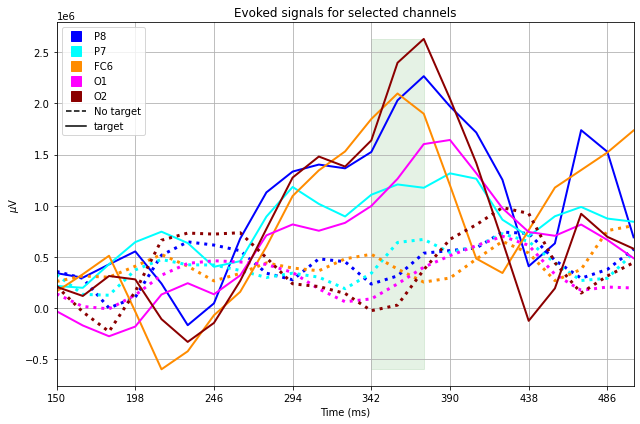

In [296]:
ts1 = np.arange(150, 500, 16) 
ts = np.arange(0, x.shape[2]/2)



t_data =  epochs_highlights_targets2_decim.get_data(picks=ch_picks, tmin=.15, tmax=.5 , units='uV')
nt_data =  epochs_highlights_notargets2_decim.get_data(picks=ch_picks, tmin=.15, tmax=.5 , units='uV')


avg_t = t_data.mean(axis=0)
avg_nt = nt_data.mean(axis=0)

plt.figure(figsize=(9, 6))
colors = ['b', 'cyan', 'darkorange', 'magenta', 'darkred', 'orchid']
legend_labels = []
for i in range(len(selected_ch)):
    mu1 = avg_t[i, :]
    mu2 = avg_nt[i, :]
    inds_ss = np.where(pvals[i, :]<0.05)[0] 

    plt.plot(ts, mu1, label = selected_ch[i], c=colors[i], lw=2,
          #  marker='.', linestyle='solid',  mfc='none', mec='b', markersize=24, markerfacecolor='white',
           )
    # plt.plot(ts[inds_ss], mu1[inds_ss], label = selected_ch[i], c=colors[i], lw=2,
    #          marker='.', linestyle=None,  mfc='none', mec=colors[i], markersize=14, markerfacecolor='white',
    #          )
    # plt.scatter(ts[inds_ss], mu1[inds_ss], #label = selected_ch[i], 
    #             c='white', #colors[i], 
    #           linewidths = 2,
    #           marker = "o", #"^",
    #           edgecolor ="g",
    #           s = 200)

    plt.plot(ts, mu2, label = selected_ch[i] + ' non err', c=colors[i], ls='dotted', mec='k',
           mew=9, lw = 3)
    label_ = mlines.Line2D([], [], color=colors[i], marker='s', linestyle='None',
                          markersize=10, label=selected_ch[i] )
    legend_labels.append(label_)

    # plt.scatter(inds_ss, mu2[inds_ss], label = None, marker='o', edgecolors = 'g',c='g',# mec='k', mfc='g',
    #         s = 30
    #         # , alpha = .951
    #         )
    # plt.scatter(inds_ss, mu1[inds_ss], label = None, marker='o', edgecolors = 'g',c='g',# mec='k', mfc='g',
    #         s = 30
    #         # , alpha = .951
    #         )


and_inds_p = ((pvals[2,:]<.05).astype(int) +  (pvals[0,:]<.05).astype(int)
+  (pvals[1,:]<.05).astype(int)+  (pvals[3,:]<.05).astype(int)
+  (pvals[4,:]<.05).astype(int) #+  (pvals[5,:]<.01).astype(int)

)

label_ = mlines.Line2D([], [], color='k', marker=None, linestyle='--',
                        markersize=10, label='No target' )
legend_labels.append(label_)


label_ = mlines.Line2D([], [], color='k', marker=None, linestyle='-',
                        markersize=10, label='target' )
legend_labels.append(label_)
plt.fill_between(ts, avg_t.min(), avg_t.max(),# avg_nonerr.min()-.3, avg_err.max(),
                where=and_inds_p>0, #(pvals[2,:]<.01) +  (pvals[0,:]<.01)+  (pvals[1,:]<.01)+  (pvals[3,:]<.01) , 
                 color='g',
                alpha=0.1)


# np.arange(ts.shape[0])>4 + np.arange(ts.shape[0])>4
# plt.fill_between(ts, -2, 9.6,# avg_nonerr.min()-.3, avg_err.max(),
#                 where=and_inds_p>2, #(pvals[2,:]<.01) +  (pvals[0,:]<.01)+  (pvals[1,:]<.01)+  (pvals[3,:]<.01) , 
#                  color='r',
#                 alpha=0.1)


xticks_loc = np.arange(0, ts.shape[0], 3)
plt.xticks(xticks_loc ,labels = ts1[xticks_loc])
plt.grid()
plt.legend()
plt.legend(handles=legend_labels)
plt.xlim([0, 22])
# plt.ylim([-2, 9.6])
plt.title('Evoked signals for selected channels')
plt.xlabel('Time (ms)')
plt.ylabel('$\mu$V')
plt.tight_layout()



# fig_filename = 'pvals_t_selected_feat.png'
# plt.savefig(fig_filename, dpi = 300, bbox_inches = 'tight', pad_inches = .21)


In [376]:
selected_channels

['P8', 'FC6', 'O1', 'O2', 'P7']

In [394]:


selected_ = ['P8', 'FC6']
feat_selected_t_data =  epochs_highlights_targets2_decim.get_data(picks=selected_, tmin=.1, tmax=.5 , units='uV')

feat_selected_nt_data =  epochs_highlights_notargets2_decim.get_data(picks=selected_, tmin=.1, tmax=.5 , units='uV')

In [315]:

def get_avg_trials(x_data, y_data, num_samples=3):

    x_avg_= np.zeros((int(x_data.shape[0]/num_samples), x_data.shape[1], x_data.shape[2]))
    print(x_avg_.shape)
    y_avg_ = np.zeros((int(x_data.shape[0]/num_samples)))
    j = 0
    for i in np.arange(0, x_data.shape[0], num_samples):
        x_avg_[j, :, :] = x_data[i:i+num_samples, :, : ].mean(axis=0)
        y_avg_[j] = y_data[i]
        j+=1
    return x_avg_, y_avg_

In [386]:
feat_selected_t_data.shape, feat_selected_nt_data.shape

((345, 2, 26), (1095, 2, 26))

In [395]:




#Construct the 2D feature matrix
x_feat = np.zeros((x.shape[0], len(selected_), feat_selected_t_data.shape[2]))
x_feat[:1095, :, :] = feat_selected_nt_data

x_feat[1095:, :, :] = feat_selected_t_data

x_feat = x_feat.reshape(x.shape[0], -1)

In [802]:
ind_selected_ch, selected_ch

([5, 6, 7, 8, 10], ['P8', 'P7', 'FC6', 'O1', 'O2'])

In [308]:
x_avg_3 = np.concatenate([feat_selected_nt_data, feat_selected_t_data])


In [316]:
x_avg_3, y_avg_3 = get_avg_trials(x_avg_3, y)

(480, 5, 26)


In [779]:
nt_inds = np.where(y<1)
nt_inds[0]

array([  0,   1,   3,   5,   6,   7,   8,  10,  11,  12,  13,  15,  17,
        18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  30,  32,  34,
        35,  36,  37,  39,  40,  41,  43,  44,  45,  46,  49,  50,  51,
        52,  53,  54,  57,  58,  59,  60,  62,  63,  64,  65,  67,  68,
        70,  71,  73,  74,  75,  77,  78,  79,  80,  81,  82,  84,  85,
        86,  88,  89,  91,  92,  94,  95,  96,  97,  98, 101, 102, 103,
       104, 106, 107, 108, 110, 111, 112, 113, 115, 116, 117, 118, 121,
       122, 123, 124, 125, 127, 128, 130, 131, 133, 134, 135, 136, 137,
       138, 140, 142, 143, 144, 145, 147, 149, 150, 151, 152, 153, 154,
       156, 157, 159, 160, 161, 162, 164, 165, 167, 169, 170, 171, 172,
       174, 175, 177, 178, 179, 180, 181, 182, 184, 185, 187, 188, 190,
       191, 192, 193, 194, 197, 198, 199, 200, 202, 203, 204, 205, 207,
       208, 209, 210, 212, 213, 215, 216, 218, 219, 221, 222, 223, 224,
       226, 227, 228, 229, 231, 233, 234, 235, 236, 237, 238, 24

In [780]:
y.sum(), y.shape

(96.0, (384,))

In [803]:
x_feat = x[:, ind_selected_ch[2:], :].reshape(x.shape[0], -1)

In [783]:
nt_inds_chosen = np.random.choice(nt_inds[0], 180)
inds_chosen = np.asarray(list(nt_inds_chosen) + list(np.where(y>0)[0]))

In [804]:
X_train, X_test, y_train, y_test = train_test_split(
#     x_pca[inds_chosen, :],
#     x_avg_3.reshape((x_avg_3.shape[0], -1)),
    x_feat[inds_chosen, :],

    y[inds_chosen], test_size=0.2, 
    stratify=y[inds_chosen], 
    shuffle=True,  random_state=0)

In [398]:
# res_svm_fc_x_cv_nested = []
# params = []
# gammas =[.001, .005, .01, .05, .09, 'auto', .1]
# C_OPTIONS = [1, 3, 10, 100]
# for gamma in gammas:
#     for c_ in C_OPTIONS:
#         pr_scores, recall_scores, f1_scores, mcr_scores, metrics, _ = run_kfold_cv(X_train, y_train, clf_obj=
#                                                     make_pipeline(StandardScaler(),
#                       SVC(gamma=gamma, C=c_))
#       )
#     res_svm_fc_x_cv_nested.append(metrics)
#     params.append((gamma, c_))
#     print(f"for gamma = {gamma}, C= {c_} : {np.mean(recall_scores), np.mean(pr_scores)},"
#                                   f" {np.mean(f1_scores),  np.mean(mcr_scores)}")

In [707]:
def get_events_annot_dict_map(data):
    events_from_annot, event_dict = mne.events_from_annotations(data)

    mapping={}
    for k,v in event_dict.items():
        mapping[v] = k
        
    return events_from_annot, event_dict, mapping

events_from_annot, event_dict, mapping = get_events_annot_dict_map(raw_filt2)
events_from_annot , mapping

(array([], shape=(0, 3), dtype=int64), {})

In [709]:
event_arr_orig.max()/128

827.0

In [805]:
 pr_scores, recall_scores, f1_scores, mcr_scores, metrics, _ = run_kfold_cv(X_train, y_train, n_folds=20,  clf_obj=
                                                    make_pipeline(StandardScaler(),
                      SVC(gamma='auto', C=1000))
      )
    
print(f" {np.mean(recall_scores), np.mean(pr_scores)},"
                              f" {np.mean(f1_scores),  np.mean(mcr_scores)}")

 tn, fp, fn, tp: (5, 3, 1, 2)
 tn, fp, fn, tp: (6, 2, 0, 3)
 tn, fp, fn, tp: (6, 2, 2, 1)
 tn, fp, fn, tp: (4, 3, 3, 1)
 tn, fp, fn, tp: (5, 2, 3, 1)
 tn, fp, fn, tp: (5, 2, 2, 2)
 tn, fp, fn, tp: (6, 1, 4, 0)
 tn, fp, fn, tp: (6, 1, 2, 2)
 tn, fp, fn, tp: (7, 0, 2, 2)
 tn, fp, fn, tp: (5, 2, 3, 1)
 tn, fp, fn, tp: (7, 0, 1, 3)
 tn, fp, fn, tp: (7, 0, 3, 1)
 tn, fp, fn, tp: (3, 4, 2, 2)
 tn, fp, fn, tp: (6, 1, 4, 0)
 tn, fp, fn, tp: (5, 2, 2, 2)
 tn, fp, fn, tp: (3, 4, 4, 0)
 tn, fp, fn, tp: (4, 3, 2, 2)
 tn, fp, fn, tp: (5, 2, 2, 2)
 tn, fp, fn, tp: (7, 0, 3, 1)
 tn, fp, fn, tp: (5, 2, 3, 1)
 Mean [5.35 1.8  2.4  1.45]
 (0.3875, 0.4741666666666666), (0.39650793650793653, 0.3818181818181817)


In [ ]:
p8: 
     Mean [7.82 2.58 3.18 2.34]
 (0.42333333333333334, 0.4836031746031746), (0.43541691641691643, 0.3619166666666666)

In [171]:

def run_kfold_cv(X_data, y_data, 
                 clf_obj=LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
                 n_folds=10,
                 nested_cv=False,
                 probs=False,
                 thr=.5, 
                 random_state=0):
    skf = StratifiedKFold(n_splits=n_folds, 
                        shuffle=True,
                        random_state=random_state,
                        )
    skf.get_n_splits(X_data, y_data,  )
  # print(skf)
    scores = []
    conf_matrix = np.zeros((n_folds, 4))
    fold_idx=0

    mcr_scores = []
    pr_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    acc_scores = []
    for train_index, test_index in skf.split(X_data, y_data):
      # print(test_index)
      # print("TRAIN:", train_index, "TEST:", test_index)
        X_train_fold, X_test_fold = X_data[train_index], X_data[test_index]
        y_train_fold, y_test_fold = y_data[train_index], y_data[test_index].astype(int)
        clf =  fit_clf(X_train_fold, y_train_fold, copy.deepcopy(clf_obj) )
      # 
      # clf.fit(X_train_fold, y_train_fold) 
        if nested_cv:
            print(f" Best parameters: {clf.best_params_}")
        if probs:
            pred =  clf.predict_proba(X_test_fold)[:,1]
            y_pred_ = np.zeros_like(pred) + min(y_train_fold)
            y_pred_[pred>thr] = 1
            y_pred_ = y_pred_.astype(int)
        # print(y_pred_[:10])
        else:
            pred = clf.predict(X_test_fold)
            y_pred_ = pred

        y_true = y_test_fold

        auc_scores.append(roc_auc_score(y_true, pred))

        pr_scores.append(precision_score(y_true, y_pred_))
        f1_scores.append(f1_score(y_true, y_pred_))
        recall_scores.append(recall_score(y_true, y_pred_))
        acc_scores.append(accuracy_score(y_true, y_pred_))

        tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_).ravel()
        mcr_scores.append((fp+fn)/y_true.shape[0])

        print(f" tn, fp, fn, tp: {tn, fp, fn, tp}")
        conf_matrix[fold_idx, :] = [tn, fp, fn, tp ]
        fold_idx+=1
    test_metrics = {
      'pr_scores': pr_scores,
      'recall_scores': recall_scores,
      'f1_scores': f1_scores,
      'mcr_scores': mcr_scores,
      'acc_scores': acc_scores, 
      'cm_all': conf_matrix,

      'auc_scores': auc_scores
     }
      
    print(f" Mean {conf_matrix.mean(axis=0)}")
    return  pr_scores, recall_scores, f1_scores, mcr_scores , test_metrics, clf

def fit_clf(xtr, ytr,  clf):
  # clf =  copy.deepcopy(clf_obj) 
  # print(clf)
    clf.fit(xtr, ytr) 
    return clf 

In [333]:
y_train.sum()

92.0

In [787]:
# LDA
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=1)

pr_scores, recall_scores, f1_scores, mcr_scores, metrics, _= run_kfold_cv(X_train,
                                                                          y_train,
                                                                          clf_obj=clf,
                                                                          n_folds=5,
                                                                          # probs=True,
                                                                          # thr=.6
                                                                          )
np.mean(recall_scores), np.mean(pr_scores), np.mean(f1_scores), np.mean(mcr_scores), np.mean(metrics['auc_scores'])


 tn, fp, fn, tp: (16, 13, 9, 6)
 tn, fp, fn, tp: (19, 10, 6, 9)
 tn, fp, fn, tp: (20, 9, 5, 10)
 tn, fp, fn, tp: (15, 13, 8, 8)
 tn, fp, fn, tp: (17, 11, 9, 7)
 Mean [17.4 11.2  7.4  8. ]


(0.5208333333333333,
 0.41712614870509607,
 0.4629570747217806,
 0.42272727272727273,
 0.5643575533661741)

In [400]:
with open(datadir + 'x_y_002.pickle', mode='rb') as opened_file:
    (x_feat_02, y_02)  = pickle.load( opened_file)

In [788]:

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=1)
clf = make_pipeline(StandardScaler(),
                      SVC(gamma='auto', C=100, probability=True))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma='auto', probability=True))])

In [794]:
thr = .35
pred = clf.predict_proba(
    X_test)[:, 1]
pred_ = np.zeros_like(pred)
pred_[pred>thr] = 1
get_performance(y_test, pred_)

{'pr_scores': 0.48,
 'recall_scores': 0.631578947368421,
 'f1_scores': 0.5454545454545454,
 'mcr_scores': 0.35714285714285715,
 'cm_all': [24, 13, 7, 12]}

In [469]:
avg_x02, avg_y02 = get_avg_trials(x_feat_02.reshape((x_feat_02.shape[0], len(selected_), -1)), y_02)

(80, 2, 26)


In [470]:
avg_x02 = avg_x02.reshape (80, -1)

In [474]:
thr = .5
pred = clf.predict_proba(
    x_feat_02)[:, 1]
pred_ = np.zeros_like(pred)
pred_[pred>thr] = 1
get_performance(y_02, pred_)

{'pr_scores': 0.35294117647058826,
 'recall_scores': 0.0967741935483871,
 'f1_scores': 0.1518987341772152,
 'mcr_scores': 0.2791666666666667,
 'cm_all': [167, 11, 56, 6]}

In [439]:
pred

array([0.64568696, 0.5180691 , 0.60841549, 0.78631131, 0.67655802,
       0.68754959, 0.73383653, 0.58687727, 0.78040203, 0.81851504,
       0.70823224, 0.63862363, 0.69070726, 0.68551051, 0.70823203,
       0.60633699, 0.80836431, 0.66115943, 0.55424591, 0.73294625,
       0.86666505, 0.63532777, 0.74199351, 0.58246034, 0.60827555,
       0.38436324, 0.59446531, 0.60049283, 0.55182853, 0.73837409,
       0.43216052, 0.66902315, 0.57414832, 0.57543195, 0.73383653,
       0.53160432, 0.64990059, 0.74078496, 0.66402195, 0.70823125,
       0.5547019 , 0.5       , 0.4602401 , 0.67085522, 0.64893023,
       0.74285225, 0.58466767, 0.59339387, 0.73953696, 0.27646568,
       0.55975325, 0.4571568 , 0.67870718, 0.81110718, 0.60819343,
       0.68360947, 0.46387362, 0.8300742 , 0.63204803, 0.70366137,
       0.75494412, 0.69995777, 0.56523211, 0.65479919, 0.55431063,
       0.51922946, 0.62606154, 0.75246956, 0.66445772, 0.71588566,
       0.76312318, 0.62643327, 0.73864626, 0.68379085, 0.71692

In [429]:
pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1])

In [196]:

def get_performance(y_true, y_pred_):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_).ravel()

    conf_matrix = [tn, fp, fn, tp ]
    test_metrics = {
    'pr_scores': precision_score(y_true, y_pred_),
    'recall_scores': recall_score(y_true, y_pred_),
    'f1_scores': f1_score(y_true, y_pred_),
    'mcr_scores': (fp+fn)/y_true.shape[0],
    'cm_all': conf_matrix,
    }
    return test_metrics

In [211]:
from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.viz import plot_epochs_image

## Try Xdown

Not setting metadata
1095 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


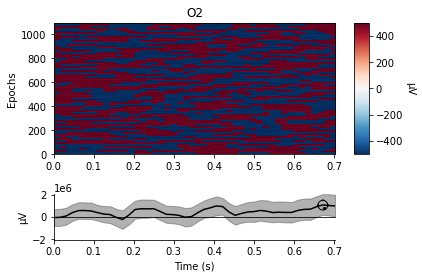

[<Figure size 432x288 with 4 Axes>]

In [212]:
ch = ['O2']
# Plot image epoch before xdawn
plot_epochs_image(epochs_highlights_notargets2_decim, picks=ch, vmin=-500, vmax=500)

Not setting metadata
345 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


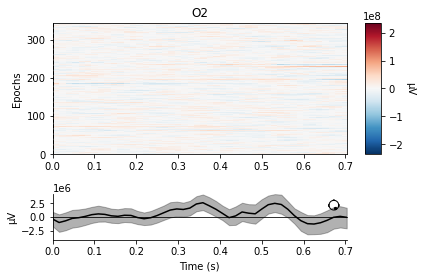

[<Figure size 432x288 with 4 Axes>]

In [244]:
# Plot image epoch before xdawn
plot_epochs_image(epochs_highlights_targets2_decim, picks=ch, )

In [225]:
selected_channels, signal_cov

(['P8', 'FC6', 'O1', 'O2', 'P7'],
 <Covariance | size : 5 x 5, n_samples : 217359, data : [[290.58793482 161.86873387 227.28159351 148.30911837 228.20831707]
  [161.86873387 154.48129698 140.86626516 123.79665216 145.36982535]
  [227.28159351 140.86626516 257.86870035 127.97074017 192.31103189]
  [148.30911837 123.79665216 127.97074017 149.72246548 145.62423158]
  [228.20831707 145.36982535 192.31103189 145.62423158 242.52085673]]>)

In [228]:
cov = np.asarray([[290.58793482, 161.86873387, 227.28159351, 148.30911837, 228.20831707],
  [161.86873387, 154.48129698 ,140.86626516, 123.79665216 ,145.36982535],
  [227.28159351, 140.86626516 ,257.86870035, 127.97074017, 192.31103189],
  [148.30911837, 123.79665216, 127.97074017 ,149.72246548, 145.62423158],
  [228.20831707, 145.36982535, 192.31103189, 145.62423158, 242.52085673]])

In [233]:
cov.shape

(5, 5)

In [234]:
# Estimates signal covariance
signal_cov = compute_raw_covariance(raw_filt2, picks=selected_ch)

# Xdawn instance
xd = Xdawn(n_components=2, signal_cov=None)

# Fit xdawn
xd.fit(epochs_highlights_notargets2_decim)

Using up to 8360 segments
Number of samples used : 217360
[done]
Computing rank from data with rank='full'
    EEG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.


Xdawn(correct_overlap='auto', n_components=2, reg=None, signal_cov=None)

Transforming to Xdawn space
Zeroing out 12 Xdawn components
Inverse transforming to sensor space
Not setting metadata
1095 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


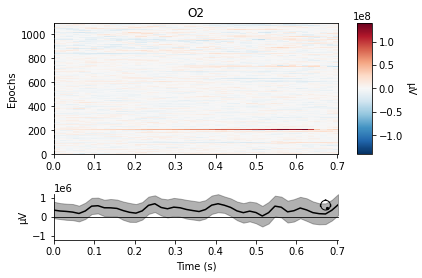

[<Figure size 432x288 with 4 Axes>]

In [243]:
epochs_denoised = xd.apply(epochs_highlights_notargets2_decim)

# Plot image epoch after Xdawn
plot_epochs_image(epochs_denoised['highlight_target_false'], picks=ch,  )

In [257]:
from mne.stats import bonferroni_correction, fdr_correction

x_0 = epochs_highlights_notargets2.get_data()[:, 0, :]
T, pval = stats.ttest_1samp(x_0, 0)
alpha = 0.05

n_samples, n_tests = x_0.shape
threshold_uncorrected = stats.t.ppf(1.0 - alpha, n_samples - 1)

reject_bonferroni, pval_bonferroni = bonferroni_correction(pval, alpha=alpha)
threshold_bonferroni = stats.t.ppf(1.0 - alpha / n_tests, n_samples - 1)

reject_fdr, pval_fdr = fdr_correction(pval, alpha=alpha, method='indep')
# threshold_fdr = np.min(np.abs(T)[reject_fdr])

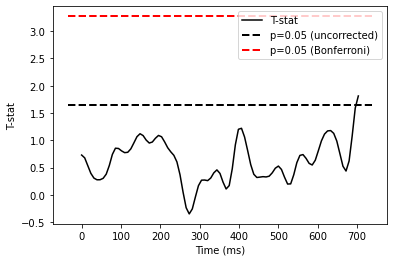

In [258]:
times = 1e3 * epochs_highlights_notargets2.times

plt.close('all')
plt.plot(times, T, 'k', label='T-stat')
xmin, xmax = plt.xlim()
plt.hlines(threshold_uncorrected, xmin, xmax, linestyle='--', colors='k',
           label='p=0.05 (uncorrected)', linewidth=2)
plt.hlines(threshold_bonferroni, xmin, xmax, linestyle='--', colors='r',
           label='p=0.05 (Bonferroni)', linewidth=2)
# plt.hlines(threshold_fdr, xmin, xmax, linestyle='--', colors='b',
#            label='p=0.05 (FDR)', linewidth=2)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("T-stat")
plt.show()

## pca

In [325]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_avg_3.reshape(x_avg_3.shape[0], -1))
x_pca = pca.transform(x_avg_3.reshape(x_avg_3.shape[0], -1))

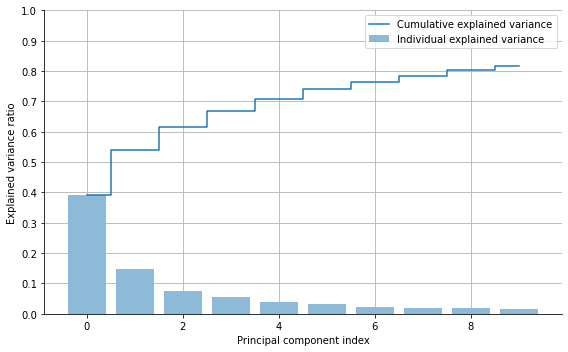

In [327]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.vlines(17, ymax=cum_sum_eigenvalues[17], ymin=0, colors='r')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.yticks(np.arange(0,1.1,.1))
plt.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='best')
plt.tight_layout()
plt.show()